[24ANN] 7조
- 20201588 박태현
- 20201590 송준규
- 20201596 양은주
- 20201610 정하연

# 2. Prepare the data
- dataset 분류: training/validation/test

## 0) Multi-GPU 할당

In [1]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"  # 사용할 GPU 번호 지정

# GPU 장치 목록 가져오기
gpus = tf.config.experimental.list_physical_devices('GPU')

# GPU 수 확인
gpu_count = len(gpus)
print("Number of GPUs:", gpu_count)

Number of GPUs: 3


## 1) Import Modules

In [2]:
# Import modules
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from keras.callbacks import EarlyStopping

#keras
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import sklearn.metrics as metrics

## 2) Preprocess the datasets

### 2-1) Constants

In [3]:
HEIGHT = 28
WIDTH = 28

### 2-2) Rotate Function

In [4]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

### 2-3) get the datasets from .csv files

In [5]:
train_balanced = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/balanced/emnist-balanced-train.csv",delimiter = ',')
test_balanced = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/balanced/emnist-balanced-test.csv", delimiter = ',')
mapp_balanced = pd.read_csv("/home/hayeon/ann/프로젝트/emnist/balanced/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train_balanced.shape, test_balanced.shape, mapp_balanced.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


### 2-4) Split datasets into trainset and testset

In [6]:
train_x_balanced = train_balanced.iloc[:,1:]
train_y_balanced = train_balanced.iloc[:,0]
del train_balanced

test_x_balanced = test_balanced.iloc[:,1:]
test_y_balanced = test_balanced.iloc[:,0]
del test_balanced

print(train_x_balanced.shape, train_y_balanced.shape, test_x_balanced.shape, test_y_balanced.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


### 2-5) Split trainset into trainset and validation set

In [7]:
# testset의 크기 = validation set의 크기
val_size = len(test_x_balanced)

# Split datasets into trainset and validation set
train_x_balanced = train_x_balanced[:-val_size]
val_x_balanced = train_x_balanced[-val_size:]
train_y_balanced = train_y_balanced[:-val_size]
val_y_balanced = train_y_balanced[-val_size:]

### 2-6) Flip and rotate images

In [8]:
train_x_balanced = np.asarray(train_x_balanced)
train_x_balanced = np.apply_along_axis(rotate, 1, train_x_balanced)
val_x_balanced = np.asarray(val_x_balanced)
val_x_balanced = np.apply_along_axis(rotate, 1, val_x_balanced)
test_x_balanced = np.asarray(test_x_balanced)
test_x_balanced = np.apply_along_axis(rotate, 1, test_x_balanced)

### 2-7) Normalize the pixel values

In [9]:
train_x_balanced = train_x_balanced.astype('float32') / 255
val_x_balanced = val_x_balanced.astype('float32') / 255
test_x_balanced = test_x_balanced.astype('float32') / 255

### 2-8) check if preprocessing has done well

In [10]:
print("train_x_balanced :", train_x_balanced.shape)
print("val_x_balanced :", val_x_balanced.shape)
print("test_x_balanced :", test_x_balanced.shape)

train_x_balanced : (94000, 28, 28)
val_x_balanced : (18799, 28, 28)
test_x_balanced : (18799, 28, 28)


- EMNIST balanced는 Trainset의 마지막 부분에 Testset과 같은 크기의 Validation set이 있다.
- 분류한 후, .shape을 통해 제대로 분리되었는지 확인하였다.

### 2-9) Calculate the number of unique label classes

In [11]:
num_classes = train_y_balanced.nunique()
print("Number of label classes:", num_classes)

Number of label classes: 47


### 2-10) EMNIST balanced의 각 클래스의 이미지 개수가 같은지 확인

In [12]:
def count_samples(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_counts_dict = dict(zip(unique_classes, class_counts))
    return class_counts_dict

In [13]:
# Train set
train_class_counts = count_samples(train_y_balanced)
print("Train set class distribution:")
for class_label, count in train_class_counts.items():
    print(f"{class_label}: {count} samples")

Train set class distribution:
0: 2000 samples
1: 2000 samples
2: 2000 samples
3: 2000 samples
4: 2000 samples
5: 2000 samples
6: 2000 samples
7: 2000 samples
8: 2000 samples
9: 2000 samples
10: 2000 samples
11: 2000 samples
12: 2000 samples
13: 2000 samples
14: 2000 samples
15: 2000 samples
16: 2000 samples
17: 2000 samples
18: 2000 samples
19: 2000 samples
20: 2000 samples
21: 2000 samples
22: 2000 samples
23: 2000 samples
24: 2000 samples
25: 2000 samples
26: 2000 samples
27: 2000 samples
28: 2000 samples
29: 2000 samples
30: 2001 samples
31: 2000 samples
32: 2000 samples
33: 2000 samples
34: 2000 samples
35: 2000 samples
36: 2000 samples
37: 2000 samples
38: 2000 samples
39: 2000 samples
40: 2000 samples
41: 2000 samples
42: 2000 samples
43: 2000 samples
44: 2000 samples
45: 1999 samples
46: 2000 samples


In [14]:
# Validation set
val_class_counts = count_samples(val_y_balanced)
print("\nValidation set class distribution:")
for class_label, count in val_class_counts.items():
    print(f"{class_label}: {count} samples")


Validation set class distribution:
0: 383 samples
1: 404 samples
2: 422 samples
3: 376 samples
4: 393 samples
5: 420 samples
6: 415 samples
7: 400 samples
8: 360 samples
9: 402 samples
10: 388 samples
11: 366 samples
12: 414 samples
13: 418 samples
14: 410 samples
15: 413 samples
16: 405 samples
17: 403 samples
18: 398 samples
19: 421 samples
20: 383 samples
21: 403 samples
22: 398 samples
23: 411 samples
24: 386 samples
25: 404 samples
26: 396 samples
27: 369 samples
28: 389 samples
29: 400 samples
30: 365 samples
31: 387 samples
32: 400 samples
33: 394 samples
34: 418 samples
35: 395 samples
36: 389 samples
37: 377 samples
38: 433 samples
39: 420 samples
40: 422 samples
41: 384 samples
42: 407 samples
43: 418 samples
44: 439 samples
45: 386 samples
46: 415 samples


- 위 Validation set 결과에서 딱 400개씩이 아닌 이유?

    : Trainset의 각 클래스 별 이미지 개수는 같지만, 그 순서가 일정하지는 않다. 즉, 클래스 간의 균형을 유지하지만, 각 클래스 내의 샘플은 무작위로 섞일 수 있다. (데이터가 순서대로 정렬되지 않기 때문에 모델이 임의의 순서에 대해서도 잘 작동하도록 일반화되는 것이다.)

In [15]:
# Test set
test_class_counts = count_samples(test_y_balanced)
print("\nTest set class distribution:")
for class_label, count in test_class_counts.items():
    print(f"{class_label}: {count} samples")


Test set class distribution:
0: 400 samples
1: 400 samples
2: 400 samples
3: 400 samples
4: 400 samples
5: 400 samples
6: 400 samples
7: 400 samples
8: 400 samples
9: 400 samples
10: 400 samples
11: 400 samples
12: 400 samples
13: 400 samples
14: 400 samples
15: 400 samples
16: 400 samples
17: 400 samples
18: 400 samples
19: 400 samples
20: 400 samples
21: 400 samples
22: 400 samples
23: 400 samples
24: 400 samples
25: 400 samples
26: 400 samples
27: 400 samples
28: 400 samples
29: 400 samples
30: 400 samples
31: 400 samples
32: 400 samples
33: 400 samples
34: 400 samples
35: 400 samples
36: 400 samples
37: 400 samples
38: 400 samples
39: 400 samples
40: 400 samples
41: 399 samples
42: 400 samples
43: 400 samples
44: 400 samples
45: 400 samples
46: 400 samples


- Train, Val, Test dataset에서 클래스 간 이미지 개수가 동일함을 확인하였다.

### 2-11) 클래스 별로 예시 이미지 출력

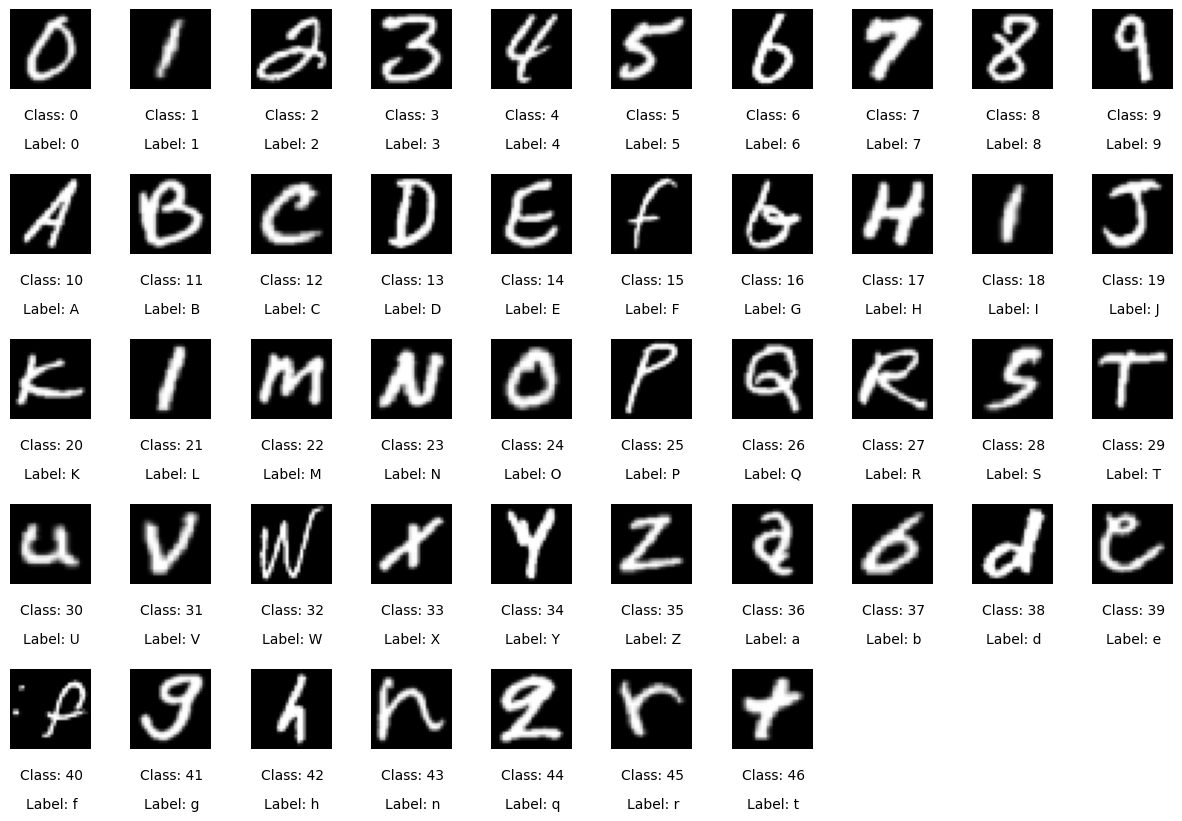

In [16]:
# 클래스별로 예시 이미지 출력
def plot_class_examples(images, labels, class_names, mapp):
    num_classes = len(class_names)
    num_rows = (num_classes // 10) + 1  # 최대 10개의 열을 가진 subplot의 행의 개수 계산
    num_cols = min(num_classes, 10)  # 최대 10개의 열을 가진 subplot의 열의 개수는 최대 클래스 개수까지
    
    plt.figure(figsize=(15, 2 * num_rows))
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_name)[0]
        example_index = class_indices[0] if class_indices.size > 0 else None  # 클래스에 속한 이미지가 있는지 확인

        plt.subplot(num_rows, num_cols, i + 1)
        if example_index is not None:
            plt.imshow(images[example_index], cmap='gray')
            plt.axis('off')
            
            # 이미지와 텍스트의 좌우 정렬을 위해 text 위치 조정
            image_width = images[example_index].shape[1]
            class_text = 'Class: {}'.format(class_name)
            label_text = 'Label: {}'.format(chr(mapp[class_name]))
            plt.text(image_width // 2, images[example_index].shape[0] + 10, class_text, fontsize=10, ha='center')
            plt.text(image_width // 2, images[example_index].shape[0] + 20, label_text, fontsize=10, ha='center')
        else:
            plt.text(0.5, 0.5, 'No image', fontsize=10, ha='center', va='center')
            plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # subplot 간격 조정
    plt.show()

# 클래스 이름 추출
class_names = sorted(train_y_balanced.unique())

# 클래스별 예시 이미지 출력
plot_class_examples(train_x_balanced, train_y_balanced, class_names, mapp_balanced)

## 3. Prepare for Distributed Training

https://www.tensorflow.org/guide/keras/distributed_training

### 3-1) 분산 학습을 위한 설정 (GPUs)

In [17]:
from tensorflow.python.client import device_lib

# 로컬 디바이스 목록 가져오기
device_lib.list_local_devices()

# gpu 이름
gpus = tf.config.experimental.list_logical_devices('GPU')

# gpu가 2개 이상이면, MirroredStrategy 인스턴스 생성
if len(gpus) > 1: 
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('\n\n Running on multiple GPUs ', [gpu.name for gpu in gpus])
    num_gpus = len(gpus)

# gpu가 1개 이하면, 디폴트 전략 설정
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('\n\n Running on single GPU', gpus[0].name)
    print('\n\n #accelerators: ', strategy.num_replicas_in_sync, '\n\n')

2024-05-09 17:10:50.984414: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 17:10:52.679775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22346 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:22:00.0, compute capability: 8.6
2024-05-09 17:10:52.681572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 22346 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:23:00.0, compute capability: 8.6
2024-05-09 17:10:52.683111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 22346 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:24:00.0,

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


 Running on multiple GPUs  ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2']


### 3-2) 분산 데이터셋 설정
- 코드 설명
    - batch_size: **GPU 개수와 배치 사이즈가 지수 관계에 있도록 설정하기 위해, num_gpus를 곱하여 문제가 없도록 하였다.**

    - suffle: 일정한 크기의 데이터가 랜덤 선택되어 버퍼에 임시 저장된 후 섞인다.
        - 너무 작은 버퍼 크기를 사용하면 데이터가 충분히 섞이지 않을 수 있다.
        - 너무 큰 버퍼 크기를 사용하면 메모리를 많이 소비하게 된다.
        - 이 과정에서 **버퍼의 한도를 설정하지 않으면 shuffle하는 시간이 학습 시간보다 오래 걸리는 현상이 발생하여, buffer_size를 10000으로 제한하였다.**

    - 한 에포크에 몇 step이 실행되는지 len(trainset)과 batch_size에 기반하여 계산하였다.
        - np.ceil

    - tf.data.Dataset.from_tensor_slices
        - .shuffle()
        - .cache()
        - .batch(batch_size)
        - .repeat()
        - .prefetch(tf.data.AUTOTUNE)

    - strategy.experimental_distribute_dataset()

- 발생하는 **Warning: AUTO sharding policy will apply DATA sharding policy**
    - Sharding: 데이터를 여러 부분으로 분할하는 프로세스

    - tensorflow에서 자동으로 데이터셋을 sharding하는 정책을 적용한다는 메시지가 출력된 것.
    
    - **tensorflow가 자동으로 데이터를 sharding하여 분산 처리하고 있음을 나타내는 것이므로, 계속 진행함.**

In [19]:
batch_size = 64 * num_gpus
shuffle_buffer_size = 10000
train_steps_per_epoch = int(np.ceil(len(train_x_balanced) / batch_size))
val_steps_per_epoch = int(np.ceil(len(val_x_balanced) / batch_size))

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_balanced, train_y_balanced)).shuffle(shuffle_buffer_size)
train_dataset = train_dataset.cache().batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x_balanced, val_y_balanced))
val_dataset = val_dataset.cache().batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x_balanced, test_y_balanced))
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

2024-05-09 17:11:58.371463: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 94000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSO